# Crop Recommendation Neural Network

In this project, I implemented a neural network to predict the crop to be planted given information about the soil and weather in the region.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Load the Data](#2)
- [ 3 - Scale the Data](#3)
- [ 4 - Defining the Model Architecture](#4)
- [ 5 - Compiling the Model](#5)
- [ 6 - Model Precision and Accuracy](#6)
- [ 7 - Plot Functions](#7)


<a name="1"></a>
## 1 - Packages 

The cell below imports all of the requires libraries for the project including NumPy, Pandas, Matplotlib, TensorFlow, Scikit Learn, and Mlextend. These libraries are used throughout to perform tasks such as reading the data from the csv, plotting the loss, training the neural network, and viewing plots concerning the data.

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

<a name="2"></a>
## 2 - Load and Scale the Data 

The `read_recommendation_csv()` function below loads the crop data and transforms the last column from categorical string values to integers. 
The `nn_df_split_scale()` function below takes in the dataframe from previous function and creates the test, cross validations and training sets after the numbers have been scaled. The sets are split into 60:20:20 for training, cross validation, and testing respectively. 


In [2]:
def read_recommendation_csv(file_path):
    df = pd.read_csv(file_path)

    df['label'] = pd.factorize(df['label'])[0]
    return df

def nn_df_split_scale(df):
    y_df = pd.DataFrame(df.pop('label'))

    X, Y = df.to_numpy(), y_df.to_numpy()
    Y = Y.flatten()

    scaler = StandardScaler()
    scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4) 

    X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5)
    return  X_train, X_test, y_train, y_test, X_test, X_cv, y_test, y_cv
    

In [3]:
df = read_recommendation_csv('Crop_recommendation.csv')

X_train, X_test, y_train, y_test, X_test, X_cv, y_test, y_cv = nn_df_split_scale(df) # get training and test sets
print(type(y_train[0]))


<class 'numpy.int64'>


<a name="4"></a>
## 4 - Defining the Model Architecture 

The following code cell defines the model architecture for this project, the model uses ReLU for hidden layers and the softmax activation function for the output layer with 22 outputs. The 22 outputs each correspond to a crop. The `l2 kernel_regularizer` was used to prevent overfitting.

In [4]:
tf.random.set_seed(2341)
model = Sequential(
    [   
        Dense(units=500, activation='relu', kernel_regularizer=l2(0.0005)),            
        Dense(units=450, activation='relu', kernel_regularizer=l2(0.0005)),
        Dense(units=350, activation='relu', kernel_regularizer=l2(0.0005)),
        Dense(units=200, activation='relu', kernel_regularizer=l2(0.0005)),
        Dense(units=100, activation='relu', kernel_regularizer=l2(0.0005)),
        Dense(units=50, activation='relu', kernel_regularizer=l2(0.0005)),
        Dense(units=22, activation='linear')
    ], name = "crop_recommendation_model" 
)


<a name="5"></a>
## 5 - Compiling the Model 

The next section of code compiles the model using the `SparseCategoricalCrossentropy` function to support multi-class classification, as well as the `from_logits=True` parameter in order to implement softmax within the model. The Adam optimizer is used to speed up the learning process for the neural network and the accuracy is recorded for the history of the model. The model is fit to the training data and provided validation data to help determine hyperparameters. 500 epochs were used for the final training, however, the model becomes close to convergence within 100 iterations.

In [5]:

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000012),
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_cv, y_cv),
    epochs=100)

Epoch 1/100
42/42 [==============================] - 3s 15ms/step - loss: 4.7530 - accuracy: 0.0803 - val_loss: 3.9049 - val_accuracy: 0.1432
Epoch 2/100
42/42 [==============================] - 0s 10ms/step - loss: 3.5917 - accuracy: 0.1636 - val_loss: 3.3071 - val_accuracy: 0.2614
Epoch 3/100
42/42 [==============================] - 0s 9ms/step - loss: 3.1505 - accuracy: 0.3295 - val_loss: 2.9487 - val_accuracy: 0.4477
Epoch 4/100
42/42 [==============================] - 0s 10ms/step - loss: 2.8467 - accuracy: 0.4455 - val_loss: 2.7036 - val_accuracy: 0.5091
Epoch 5/100
42/42 [==============================] - 0s 10ms/step - loss: 2.6218 - accuracy: 0.5235 - val_loss: 2.5075 - val_accuracy: 0.5614
Epoch 6/100
42/42 [==============================] - 0s 9ms/step - loss: 2.4378 - accuracy: 0.5788 - val_loss: 2.3395 - val_accuracy: 0.6045
Epoch 7/100
42/42 [==============================] - 0s 10ms/step - loss: 2.2679 - accuracy: 0.6568 - val_loss: 2.1841 - val_accuracy: 0.6795
Epoch 8/

<a name="6"></a>
## 6 - Accuracy and Plots

The following code evaluates the accuracy of the model and shows plots for the loss, accuracy, and confusion matrix. The F1, Precision, and Recall scores are also calculated and reported.

In [6]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100.0:.2f}%')

14/14 [==============================] - 0s 6ms/step - loss: 0.5868 - accuracy: 0.9500
Test Accuracy: 95.00%


In [10]:
def print_confusion_matrix(true_labels, predictions):
    mat = confusion_matrix(true_labels, predictions)
    plot_confusion_matrix(conf_mat=mat, figsize=(15,15))

    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f'Precision Score: {precision:.2f}')
    print(f'Recall Score: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
def plot_loss(history):
    plt.plot(history.history['loss']) # can be used for accuracy or loss
    plt.plot(history.history['val_loss'])
    plt.title('crop model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'CV'], loc ='upper left')
    plt.show()
def plot_accuracy(history):
    plt.plot(history.history['accuracy']) # can be used for accuracy or loss
    plt.plot(history.history['val_accuracy'])
    plt.title('crop model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'CV'], loc ='upper left')
    plt.show()

14/14 [==============================] - 0s 3ms/step


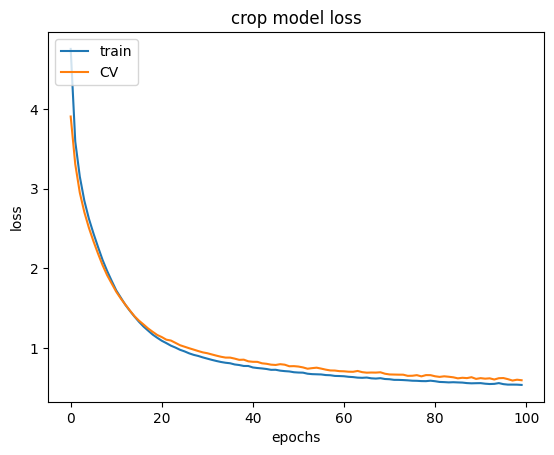

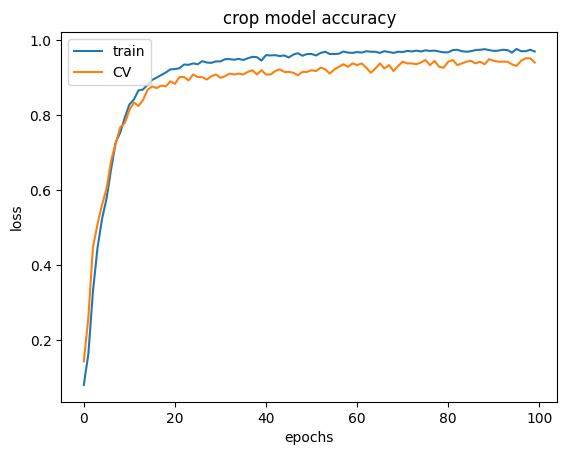

Precision Score: 0.96
Recall Score: 0.95
F1 Score: 0.95


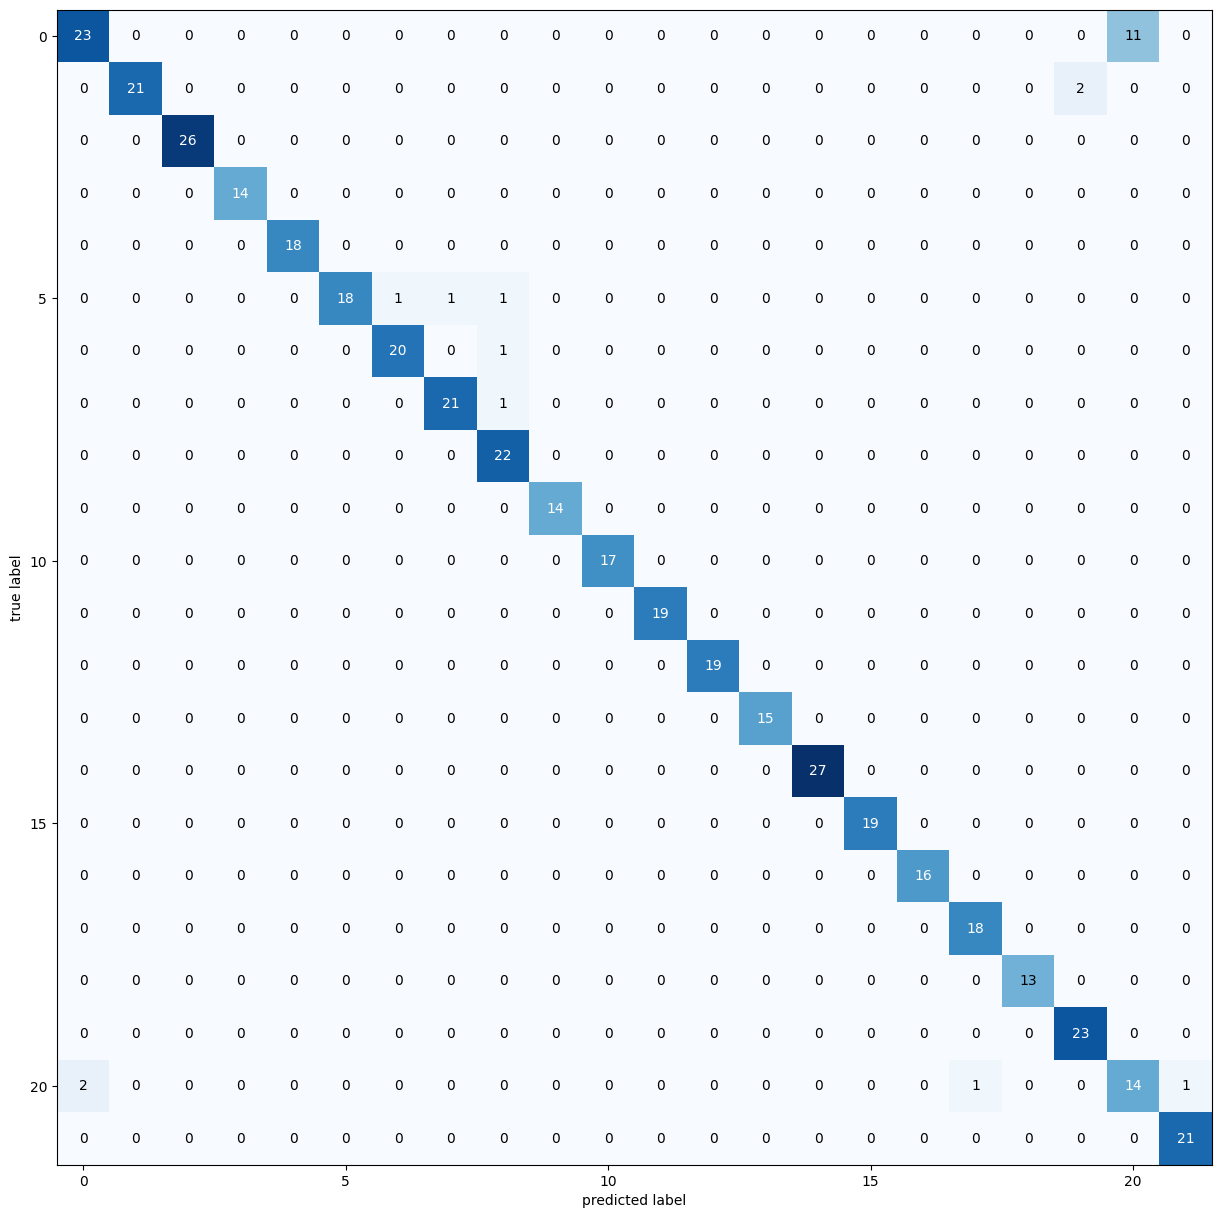

In [11]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

plot_loss(history)
plot_accuracy(history)
print_confusion_matrix(y_test, predicted_classes)

<a name="7"></a>
## 7 - Saving the Model 

The final section of code saves the weights and biases as well as the model architecture into a .keras file to be used in the Back-End of the project.

In [8]:
model.save('crop_recommender_model.keras')